# Train``

In [1]:
from glob import glob
import re
import numpy as np
def convert_path(p):
    # Replace the folder part
    
    p = re.sub(r'^idd20kII/leftImg8bit/train', 'idd20kII/gtFine/train', p)
    # Replace the filename part
    p = re.sub(r'_leftImg8bit\.jpg$', '_gtFine_polygons.json', p)
    return p

image = glob('idd20kII/leftImg8bit/train/*/*_leftImg8bit.jpg')
labels= [convert_path(p) for p in image]

print(f"Length of the dataset: {len(image)} and {len(labels)}" )
print(image[0], labels[0])

Length of the dataset: 7034 and 7034
idd20kII/leftImg8bit/train/548/0017728_leftImg8bit.jpg idd20kII/gtFine/train/548/0017728_gtFine_polygons.json


In [2]:
train_dataset=list(zip(image,labels))
train_dataset[0]

('idd20kII/leftImg8bit/train/548/0017728_leftImg8bit.jpg',
 'idd20kII/gtFine/train/548/0017728_gtFine_polygons.json')

# val

In [3]:
from glob import glob
import re
import numpy as np
def convert_path(p):
    # Replace the folder part
    
    p = re.sub(r'^idd20kII/leftImg8bit/val', 'idd20kII/gtFine/val', p)
    # Replace the filename part
    p = re.sub(r'_leftImg8bit\.jpg$', '_gtFine_polygons.json', p)
    return p

image = glob('idd20kII/leftImg8bit/val/*/*_leftImg8bit.jpg')
labels= [convert_path(p) for p in image]

print(f"Length of the dataset: {len(image)} and {len(labels)}" )
print(image[0], labels[0])

Length of the dataset: 1055 and 1055
idd20kII/leftImg8bit/val/415/frame2273_leftImg8bit.jpg idd20kII/gtFine/val/415/frame2273_gtFine_polygons.json


In [4]:
val_dataset=list(zip(image,labels))
val_dataset[0]

('idd20kII/leftImg8bit/val/415/frame2273_leftImg8bit.jpg',
 'idd20kII/gtFine/val/415/frame2273_gtFine_polygons.json')

# Converting into COCO format

In [5]:

def polygon_to_bbox(polygon):
    """
    Convert a polygon (list of [x, y] points) into a bounding box [x_min, y_min, width, height].
    """
    xs = [pt[0] for pt in polygon]
    ys = [pt[1] for pt in polygon]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    return [x_min, y_min, x_max - x_min, y_max - y_min]

def flatten_polygon(polygon):
    """
    Flatten a list of [x, y] into [x1, y1, x2, y2, ...].
    """
    return [coord for pt in polygon for coord in pt]

In [6]:
import json

# First, build the mapping using the union of labels from both datasets.
def build_category_mapping(train_dataset, val_dataset):
    label_set = set()
    # Iterate over both datasets.
    for dataset in [train_dataset, val_dataset]:
        for image_path, label_path in dataset:
            with open(label_path, 'r') as f:
                data = json.load(f)
            for obj in data.get("objects", []):
                label = obj.get("label")
                if label is not None:
                    label_set.add(label)
    # Create a consistent mapping. Sorting helps guarantee the same order.
    label_to_id = {label: idx + 1 for idx, label in enumerate(sorted(label_set))}
    return label_to_id

# Modify your conversion function to accept a pre-built label_to_id mapping.
def convert_to_coco(dataset, output_json, label_to_id):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    image_id = 1
    annotation_id = 1
    for image_path, label_path in dataset:
        with open(label_path, 'r') as f:
            data = json.load(f)
        img_width, img_height = data.get('imgWidth'), data.get('imgHeight')

        coco_output["images"].append({
            "id": image_id,
            "file_name": image_path,
            "width": img_width,
            "height": img_height
        })
        for obj in data.get("objects", []):
            label = obj.get("label")
            polygon = obj.get("polygon")
            if not polygon:
                continue

            # Use the shared mapping.
            category_id = label_to_id[label]

            # Assume flatten_polygon and polygon_to_bbox are defined elsewhere.
            segmentation = [flatten_polygon(polygon)]
            bbox = polygon_to_bbox(polygon)
            area = bbox[2] * bbox[3]

            annotation = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": segmentation,
                "bbox": bbox,
                "area": area
            }
            coco_output["annotations"].append(annotation)
            annotation_id += 1
        
        image_id += 1

    # Append the categories based on the shared mapping.
    for label, cat_id in label_to_id.items():
        coco_output["categories"].append({
            "id": cat_id,
            "name": label
        })

    # Save the COCO-style JSON file.
    with open(output_json, "w") as f:
        json.dump(coco_output, f, indent=4)
    
    print(f"COCO conversion complete! Saved to {output_json}")

# Example usage:
# Assume train_dataset and val_dataset are lists of (image_path, label_path) tuples.
label_to_id = build_category_mapping(train_dataset, val_dataset)

# Convert each dataset separately using the same label mapping.
convert_to_coco(train_dataset, "train_output.json", label_to_id)
convert_to_coco(val_dataset, "val_output.json", label_to_id)


COCO conversion complete! Saved to train_output.json
COCO conversion complete! Saved to val_output.json


In [7]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from matplotlib.patches import Patch

def show_coco_annotations(coco_data, image_id=1, show_bbox=True, show_polygon=True, show_text=True, show_legend=False):
    """
    Display an image with annotation overlays using COCO format data.
    
    Parameters:
      coco_data (dict): The loaded COCO format data containing images, annotations, and categories.
      image_id (int): ID of the image to display.
      show_bbox (bool): Whether to draw bounding boxes.
      show_polygon (bool): Whether to draw segmentation polygons.
    """
    # Find the image information from the dataset
    image_info = None
    for img in coco_data.get("images", []):
        if img["id"] == image_id:
            image_info = img
            break
    
    if not image_info:
        print(f"Image with ID {image_id} not found in the dataset")
        return
    
    # Get the image path
    image_path = image_info["file_name"]
    
    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    else:
        img = cv2.imread(image_path)
    
    # Get annotations for this image
    annotations = []
    for ann in coco_data.get("annotations", []):
        if ann["image_id"] == image_id:
            annotations.append(ann)
    
    # Create a category mapping
    category_map = {}
    for cat in coco_data.get("categories", []):
        category_map[cat["id"]] = cat["name"]
    
    # Create a copy for drawing
    overlay = img.copy()
    
    # Define colors for different categories (cycling through a set of distinct colors)
    colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Yellow
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Cyan
        (128, 0, 0),    # Maroon
        (0, 128, 0),    # Dark Green
        (0, 0, 128),    # Navy
        (128, 128, 0),  # Olive
        (128, 0, 128),  # Purple
        (0, 128, 128),  # Teal
        (192, 192, 192) # Silver
    ]
    
    # Track which categories were used
    used_categories = set()
    
    # Draw annotations
    for i, ann in enumerate(annotations):
        category_id = ann["category_id"]
        used_categories.add(category_id)
        
        # Select color based on category_id (modulo the number of colors)
        color_idx = (category_id - 1) % len(colors)
        color = colors[color_idx]
        
        if show_bbox and "bbox" in ann:
            x, y, w, h = [int(val) for val in ann["bbox"]]
            cv2.rectangle(overlay, (x, y), (x+w, y+h), color, 2)
            
            # Add annotation ID and category text if category name is available
            category_text = category_map.get(category_id, f"Cat: {category_id}")
            label_text = f"ID: {ann['id']}, {category_text[:15]}"
            
            # Add background to text for better visibility
            text_size, _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(overlay, (x, y-text_size[1]-10), (x+text_size[0]+10, y), 
                          (0, 0, 0), -1)
            
            # Add text on the background
            cv2.putText(overlay, label_text, (x+5, y-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        if show_polygon and "segmentation" in ann:
            for seg in ann["segmentation"]:
                # Convert segmentation coordinates to integer points
                pts = np.array(seg, dtype=np.float32).reshape(-1, 2).astype(np.int32)
                cv2.polylines(overlay, [pts], isClosed=True, color=color, thickness=2)
    
    # Convert from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.imshow(image_rgb)
    ax.set_title(f"Image ID: {image_id}, File: {os.path.basename(image_path)}")
    ax.axis("off")
    
    # Add legend for categories
    legend_elements = []
    for cat_id in sorted(used_categories):
        if cat_id in category_map:
            color_idx = (cat_id - 1) % len(colors)
            color_rgb = [c/255 for c in colors[color_idx]]
            legend_elements.append(
                Patch(facecolor=color_rgb, edgecolor='black',
                     label=f"{cat_id}: {category_map[cat_id]}")
            )
        else:
            color_idx = (cat_id - 1) % len(colors)
            color_rgb = [c/255 for c in colors[color_idx]]
            legend_elements.append(
                Patch(facecolor=color_rgb, edgecolor='black',
                     label=f"Category {cat_id}")
            )
    
    # Add legend if there are categories to display
    if legend_elements:
        ax.legend(handles=legend_elements, loc='upper right', 
                 title="Categories", fontsize='small')
    
    plt.tight_layout()
    plt.show()
    


In [8]:
# Validation Dataset

In [9]:
# Convert to COCO format

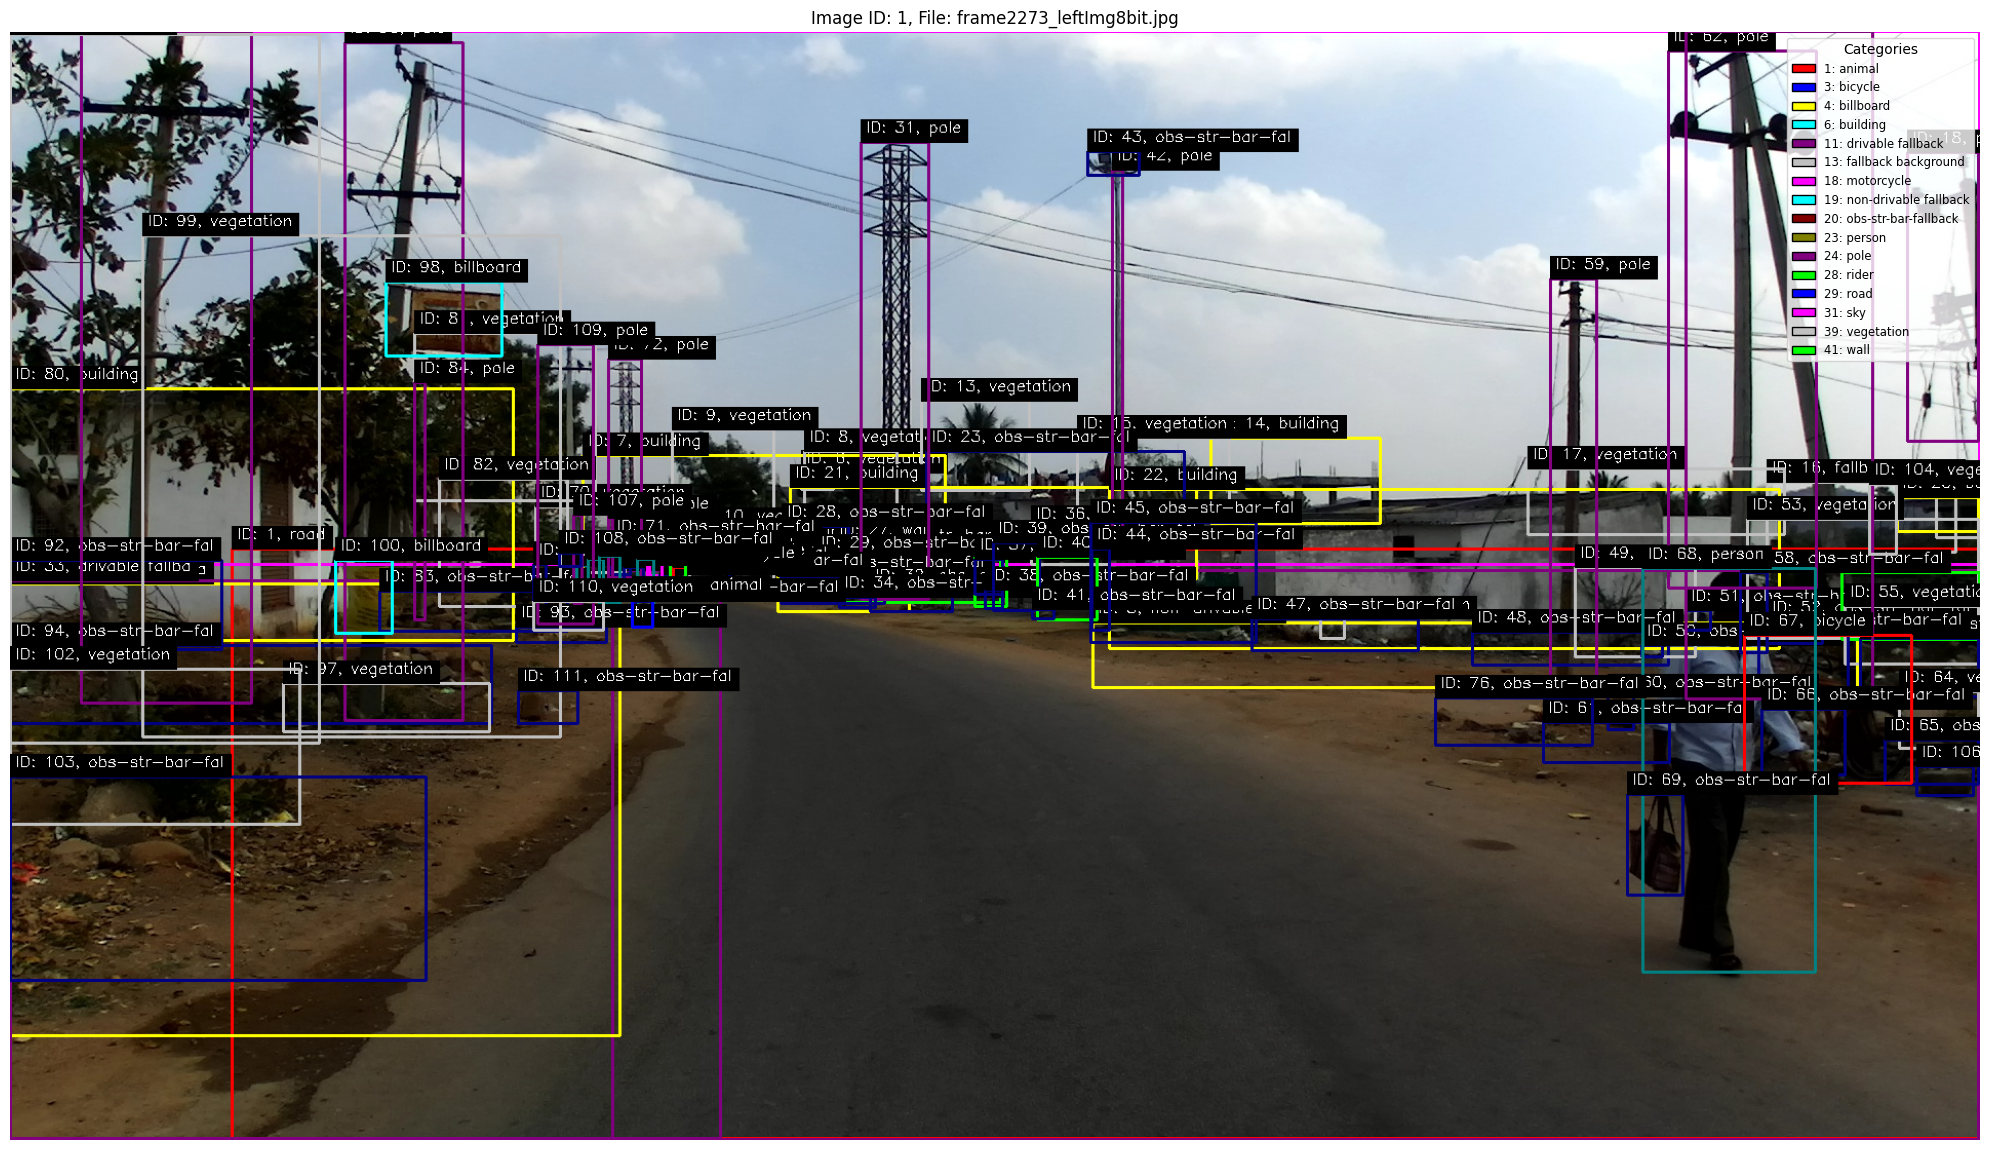

In [12]:
show_coco_annotations(json.load(open('val_output.json')), image_id=1, show_bbox=True, show_polygon=False)

In [13]:
convert_to_coco(val_dataset[:1], "test_output.json", label_to_id)

COCO conversion complete! Saved to test_output.json
